In [5]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

from catboost import CatBoostRegressor, Pool, cv, CatBoostEncoder
from catboost import MetricVisualizer

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

from scipy.stats import boxcox
from os import listdir

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

import shap
shap.initjs()

ImportError: cannot import name 'CatBoostEncoder' from 'catboost' (C:\Users\bealm\anaconda3\Lib\site-packages\catboost\__init__.py)

In [6]:
data = pd.read_csv('Previsão de Vendas _ CatBost - Worksheet (6).csv')

In [7]:
data.shape

(610, 8)

In [8]:
data.head()

,IdCliente,CodigoProduto,Nome,Quantidade,Estado,QuantidadePorEstado,Valor,Data
0,24253,653.0,POMADA MODELADORA CAPILAR MASCULINA JACK BARBE...,54.0,São Paulo - SP,5.0,"1.325,05",01/05/2024
1,9595,667.0,POMADA MODELADORA JACK & BARBER MORANGO EXTRA ...,54.0,Mato Grosso do Sul - MS,1.0,"1.123,40",01/05/2024
2,18451,693.0,Kit de 5 rolos de gola higiênica - Rolo com 10...,49.0,Paraná - PR,1.0,"48,46",01/05/2024
3,8773,649.0,ESCOVINHA DE DISFARCE E DEGRADE PARA BARBEIRO ...,46.0,São Paulo - SP,10.0,"4.203,16",02/05/2024
4,21019,655.0,Pomada Modeladora Undercut Incolor Classic 150g,42.0,Santa Catarina - SC,1.0,"1.405,53",02/05/2024


In [9]:
data['Data'] = pd.to_datetime(data['Data'], dayfirst=True, errors='coerce')

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 610 entries, 0 to 609
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   IdCliente            610 non-null    int64         
 1   CodigoProduto        275 non-null    float64       
 2   Nome                 275 non-null    object        
 3   Quantidade           275 non-null    float64       
 4   Estado               112 non-null    object        
 5   QuantidadePorEstado  112 non-null    float64       
 6   Valor                112 non-null    object        
 7   Data                 112 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(3), int64(1), object(3)
memory usage: 38.3+ KB


In [11]:
data[data.Nome.isnull()].head()


,IdCliente,CodigoProduto,Nome,Quantidade,Estado,QuantidadePorEstado,Valor,Data
275,25903,NaN,NaN,NaN,NaN,NaN,NaN,NaT
276,25447,NaN,NaN,NaN,NaN,NaN,NaN,NaT
277,22715,NaN,NaN,NaN,NaN,NaN,NaN,NaT
278,25365,NaN,NaN,NaN,NaN,NaN,NaN,NaT
279,25835,NaN,NaN,NaN,NaN,NaN,NaN,NaT


In [12]:
data.loc[data.Nome.isnull()==False, "lowercase_descriptions"] = data.loc[
    data.Nome.isnull()==False,"Nome"
].apply(lambda l: l.lower())

data.lowercase_descriptions.dropna().apply(
    lambda l: np.where("nan" in l, True, False)
).value_counts()

lowercase_descriptions
False    275
Name: count, dtype: int64

In [13]:
data.lowercase_descriptions.dropna().apply(
    lambda l: np.where("" == l, True, False)
).value_counts()

lowercase_descriptions
False    275
Name: count, dtype: int64

In [14]:
data.loc[data.lowercase_descriptions.isnull()==False, "lowercase_descriptions"] = data.loc[
    data.lowercase_descriptions.isnull()==False, "lowercase_descriptions"
].apply(lambda l: np.where("nan" in l, None, l))

In [15]:
data = data.loc[(data.IdCliente.isnull()==False) & (data.lowercase_descriptions.isnull()==False)].copy()

In [16]:
data.isnull().sum().sum()


652

In [17]:
data["Data"] = pd.to_datetime(data.Data, cache=True)

data.Data.max() - data.Data.min()

Timedelta('27 days 00:00:00')

In [18]:
print("Datafile starts with timepoint {}".format(data.Data.min()))
print("Datafile ends with timepoint {}".format(data.Data.max()))

Datafile starts with timepoint 2024-05-01 00:00:00
Datafile ends with timepoint 2024-05-28 00:00:00


In [19]:
data.CodigoProduto.nunique()


275

C:\Users\bealm\AppData\Local\Temp\ipykernel_26936\2655793325.py:15: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.round(CodigoProduto_counts / data.shape[0] * 100, 2),


Text(0, 0.5, 'Frequência')

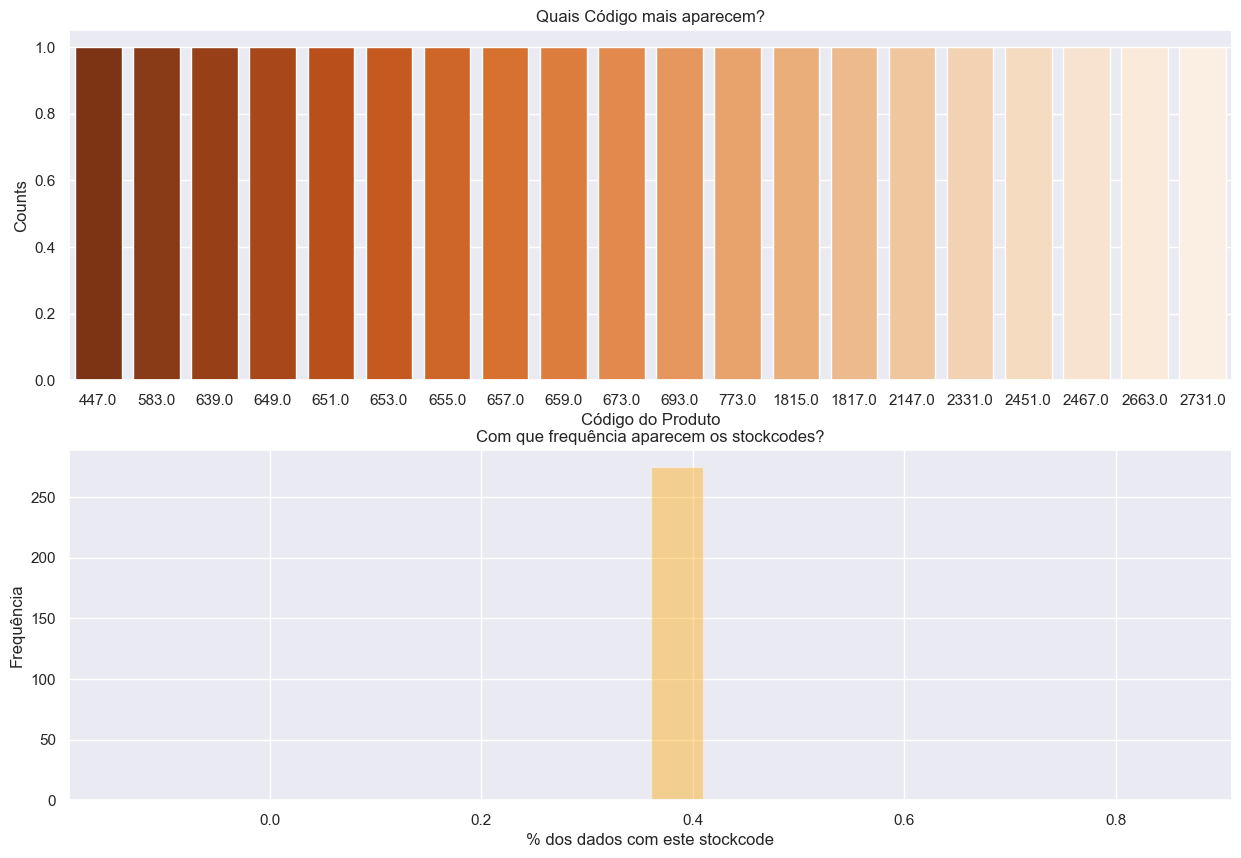

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns


CodigoProduto_counts = data.CodigoProduto.value_counts().sort_values(ascending=False)
fig, ax = plt.subplots(2,1,figsize=(15,10))
sns.barplot(x=CodigoProduto_counts.iloc[0:20].index,
            y=CodigoProduto_counts.iloc[0:20].values,
            ax=ax[0], palette="Oranges_r")
ax[0].set_ylabel("Counts")
ax[0].set_xlabel("Código do Produto")
ax[0].set_title("Quais Código mais aparecem?")

# Plotando o histograma de distribuição
sns.distplot(np.round(CodigoProduto_counts / data.shape[0] * 100, 2),
             kde=False,
             bins=20,
             ax=ax[1], color="Orange")
ax[1].set_title("Com que frequência aparecem os stockcodes?")
ax[1].set_xlabel("% dos dados com este stockcode")
ax[1].set_ylabel("Frequência")

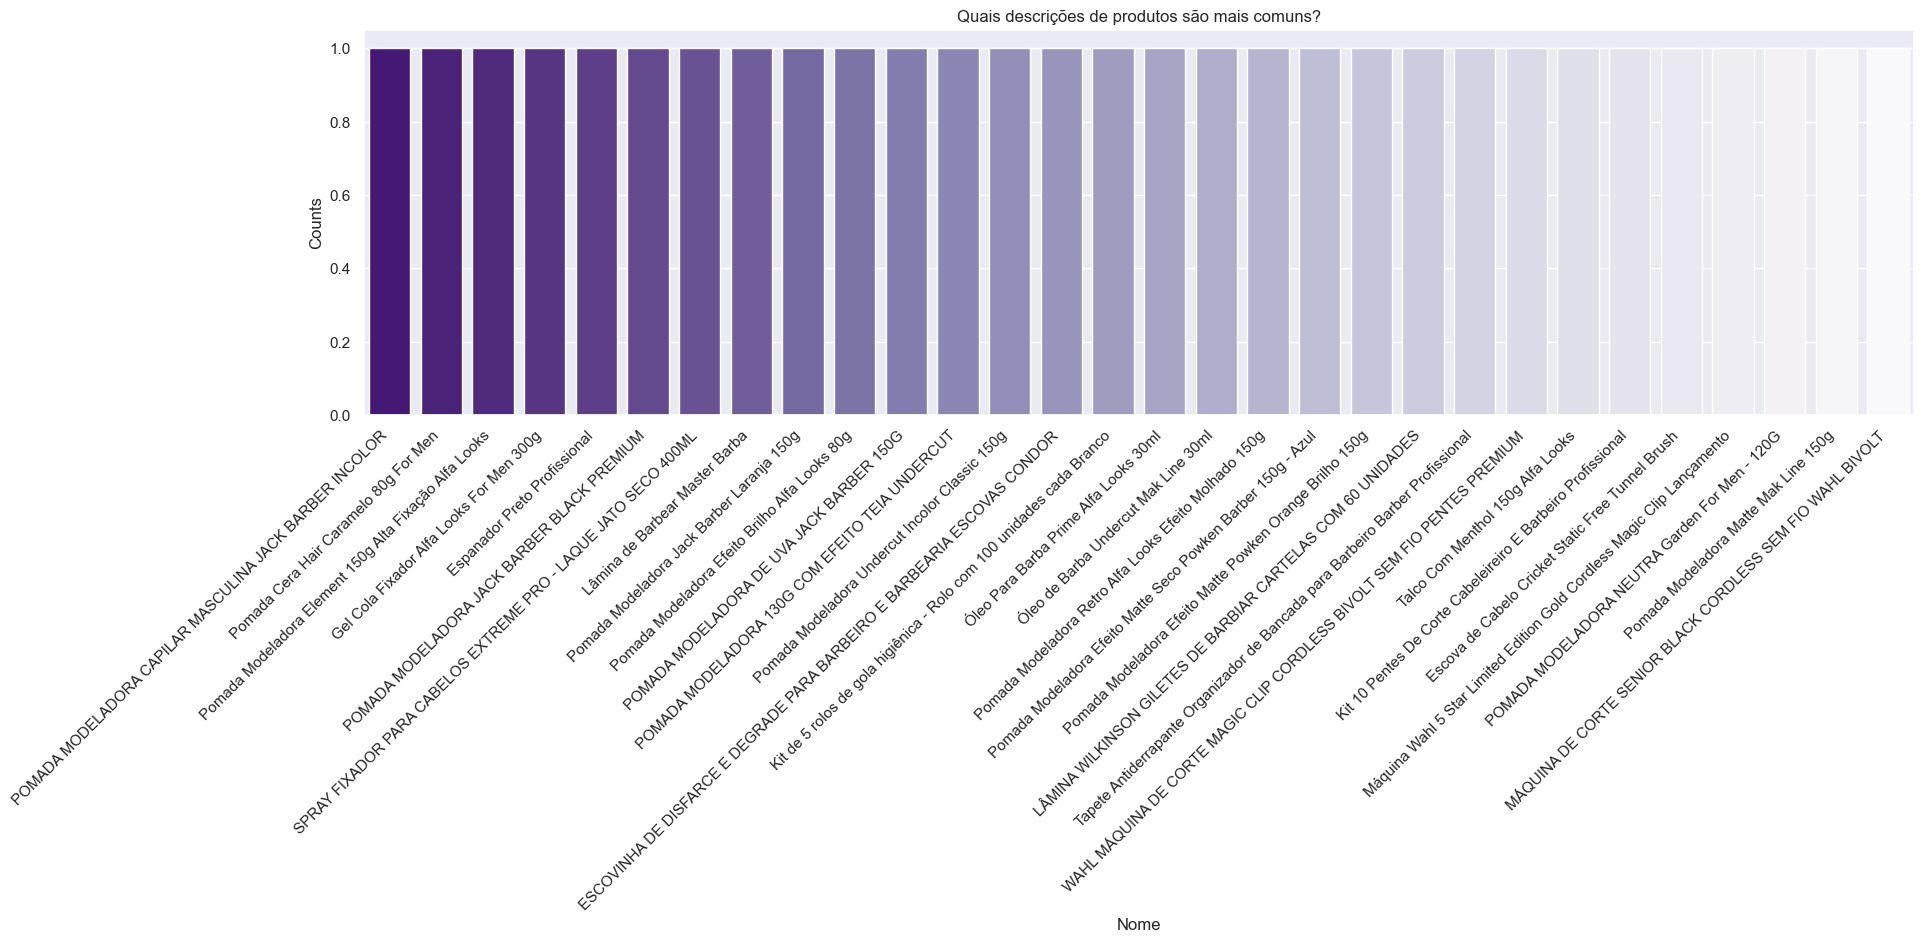

In [21]:
Nome_counts = data['Nome'].value_counts().sort_values(ascending=False).iloc[0:30]


plt.figure(figsize=(20, 5))
barplot = sns.barplot(x=Nome_counts.index, y=Nome_counts.values, palette="Purples_r")
plt.ylabel("Counts")
plt.title("Quais descrições de produtos são mais comuns?")


barplot.set_xticklabels(barplot.get_xticklabels(), rotation=45, horizontalalignment='right')

plt.show()



In [22]:
  def count_lower_chars(l):
    return sum(1 for c in l if c.islower())

In [23]:
data["DescriptionLength"] = data.Nome.apply(lambda l: len(l))
data["LowCharsInDescription"] = data.Nome.apply(lambda l: count_lower_chars(l))

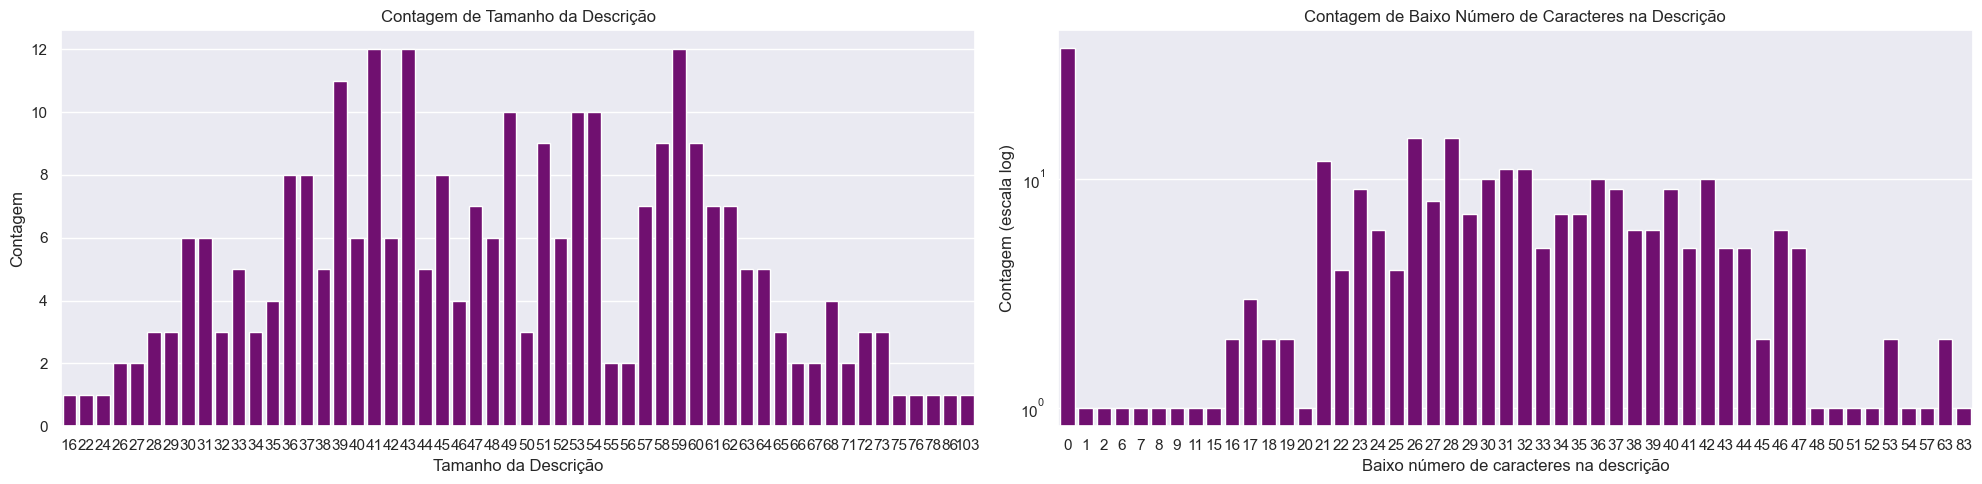

In [24]:
# Criando uma figura com dois subplots lado a lado
fig, ax = plt.subplots(1, 2, figsize=(20, 5))

# Gráfico da esquerda: contagem de DescriptionLength
sns.countplot(data=data, x='DescriptionLength', ax=ax[0], color="Purple")
ax[0].set_ylabel('Contagem')
ax[0].set_xlabel('Tamanho da Descrição')
ax[0].set_title('Contagem de Tamanho da Descrição')

# Gráfico da direita: contagem de LowCharsInDescription com escala logarítmica
sns.countplot(data=data, x='LowCharsInDescription', ax=ax[1], color="Purple")
ax[1].set_yscale('log')
ax[1].set_ylabel('Contagem (escala log)')
ax[1].set_xlabel('Baixo número de caracteres na descrição')
ax[1].set_title('Contagem de Baixo Número de Caracteres na Descrição')

# Ajustando o layout
plt.tight_layout()

# Exibindo os gráficos
plt.show()

In [25]:
data.CodigoProduto.nunique()

275

In [26]:
data.Nome.nunique()


275

In [27]:
data.groupby("CodigoProduto").Nome.nunique().sort_values(ascending=False).iloc[0:10]


CodigoProduto
23.0      1
2303.0    1
2329.0    1
2317.0    1
2315.0    1
2311.0    1
2309.0    1
2305.0    1
2299.0    1
2527.0    1
Name: Nome, dtype: int64

In [28]:
data.IdCliente.nunique()

145

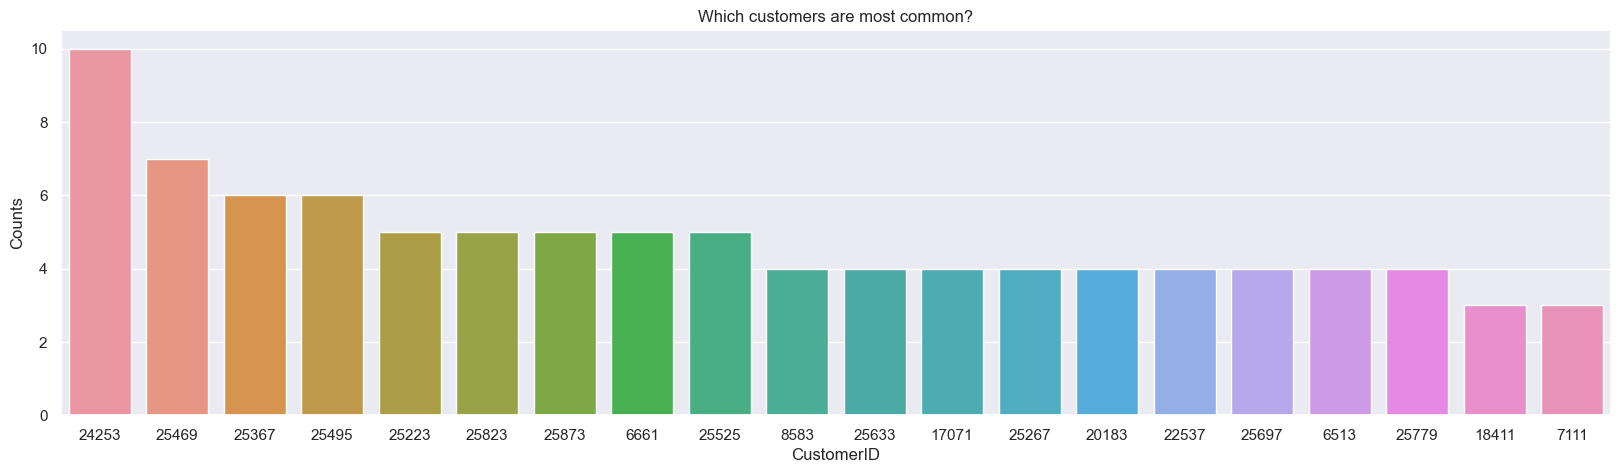

In [29]:
IdCliente_counts = data.IdCliente.value_counts().sort_values(ascending=False).iloc[0:20] 
plt.figure(figsize=(20,5))
sns.barplot(x=IdCliente_counts.index, y=IdCliente_counts.values, order=IdCliente_counts.index)
plt.ylabel("Counts")
plt.xlabel("CustomerID")
plt.title("Which customers are most common?");
#plt.xticks(rotation=90);

In [30]:
data.Estado.nunique()

19

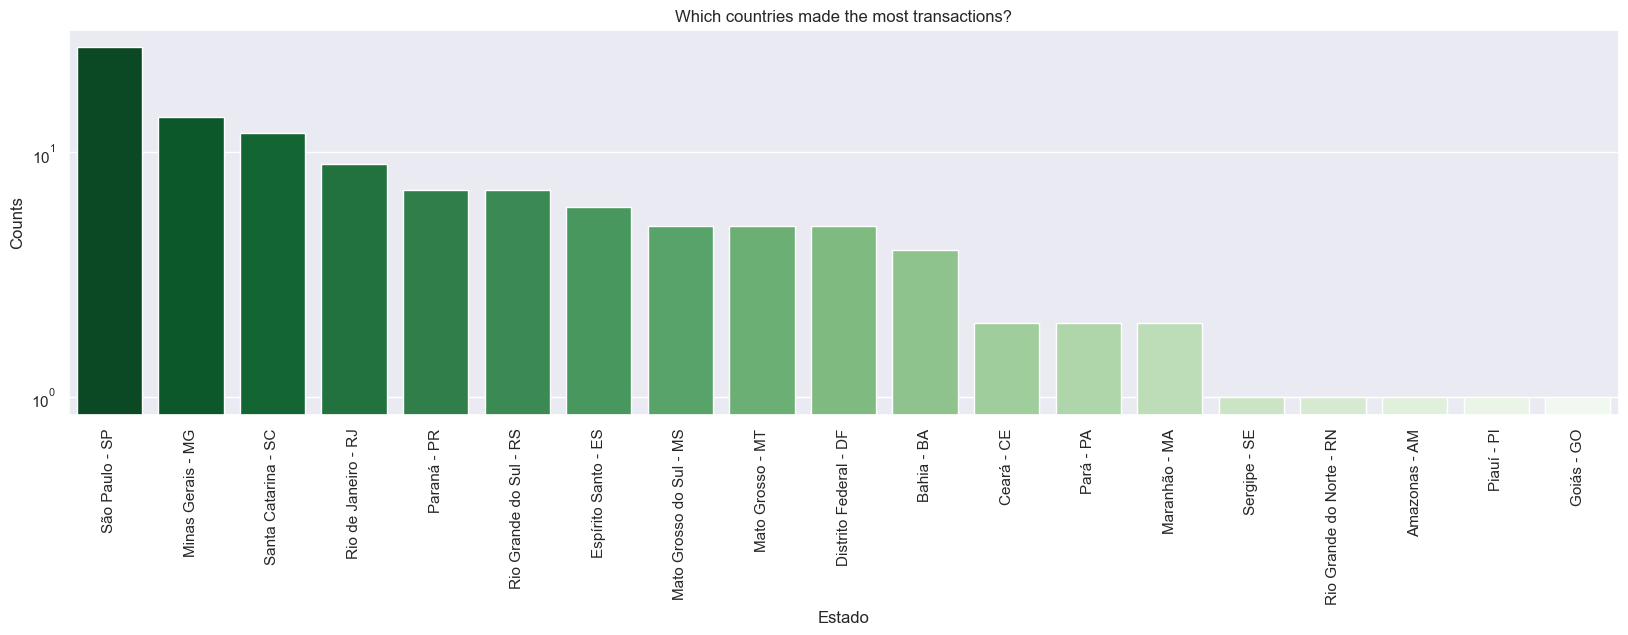

In [31]:
Estado_counts = data.Estado.value_counts().sort_values(ascending=False).iloc[0:20]
plt.figure(figsize=(20,5))
sns.barplot(x=Estado_counts.index, y=Estado_counts.values, palette="Greens_r")
plt.ylabel("Counts")
plt.title("Which countries made the most transactions?");
plt.xticks(rotation=90);
plt.yscale("log")

In [32]:
data.loc[data.Estado=="São Paulo"].shape[0] / data.shape[0] * 100

0.0

In [33]:
data.Valor.describe()

count        112
unique       111
top       859,00
freq           2
Name: Valor, dtype: object

In [34]:
data.loc[data.Valor == 0].sort_values(by="Quantidade", ascending=False).head()


,IdCliente,CodigoProduto,Nome,Quantidade,Estado,QuantidadePorEstado,Valor,Data,lowercase_descriptions,DescriptionLength,LowCharsInDescription


In [35]:
np.exp(-2)


0.1353352832366127

In [36]:
np.exp(3)


20.085536923187668

In [37]:
data.Quantidade.describe()


count    275.000000
mean       4.229091
std        7.654150
min        1.000000
25%        1.000000
50%        2.000000
75%        4.000000
max       54.000000
Name: Quantidade, dtype: float64

C:\Users\bealm\AppData\Local\Temp\ipykernel_26936\4164655719.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data.Quantidade, ax=ax[0], kde=False, color="limegreen");
C:\Users\bealm\AppData\Local\Temp\ipykernel_26936\4164655719.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.log(data.

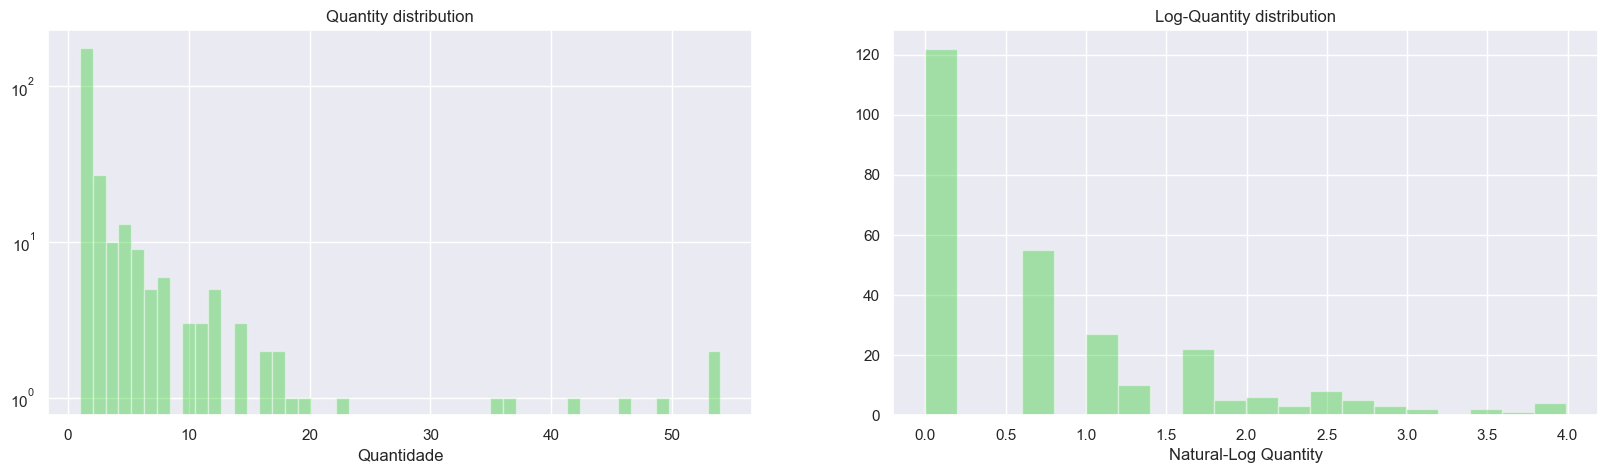

In [38]:
fig, ax = plt.subplots(1,2,figsize=(20,5))
sns.distplot(data.Quantidade, ax=ax[0], kde=False, color="limegreen");
sns.distplot(np.log(data.Quantidade), ax=ax[1], bins=20, kde=False, color="limegreen");
ax[0].set_title("Quantity distribution")
ax[0].set_yscale("log")
ax[1].set_title("Log-Quantity distribution")
ax[1].set_xlabel("Natural-Log Quantity");

In [39]:
np.exp(4)


54.598150033144236

In [40]:
np.quantile(data.Quantidade, 0.95)


14.600000000000023

In [41]:
data = data.loc[data.Quantidade < 55].copy()


In [42]:
data.head(6)

,IdCliente,CodigoProduto,Nome,Quantidade,Estado,QuantidadePorEstado,Valor,Data,lowercase_descriptions,DescriptionLength,LowCharsInDescription
0,24253,653.0,POMADA MODELADORA CAPILAR MASCULINA JACK BARBE...,54.0,São Paulo - SP,5.0,"1.325,05",2024-05-01,pomada modeladora capilar masculina jack barbe...,55,0
1,9595,667.0,POMADA MODELADORA JACK & BARBER MORANGO EXTRA ...,54.0,Mato Grosso do Sul - MS,1.0,"1.123,40",2024-05-01,pomada modeladora jack & barber morango extra ...,51,0
2,18451,693.0,Kit de 5 rolos de gola higiênica - Rolo com 10...,49.0,Paraná - PR,1.0,"48,46",2024-05-01,kit de 5 rolos de gola higiênica - rolo com 10...,68,47
3,8773,649.0,ESCOVINHA DE DISFARCE E DEGRADE PARA BARBEIRO ...,46.0,São Paulo - SP,10.0,"4.203,16",2024-05-02,escovinha de disfarce e degrade para barbeiro ...,72,0
4,21019,655.0,Pomada Modeladora Undercut Incolor Classic 150g,42.0,Santa Catarina - SC,1.0,"1.405,53",2024-05-02,pomada modeladora undercut incolor classic 150g,47,34
5,20447,657.0,POMADA MODELADORA 130G COM EFEITO TEIA UNDERCUT,36.0,São Paulo - SP,5.0,"1.382,59",2024-05-03,pomada modeladora 130g com efeito teia undercut,47,0


In [43]:
data['Valor'] = data['Valor'].str.replace(',', '') 

In [44]:
 data['Valor'] = pd.to_numeric(data['Valor'])

In [45]:
data.head(5)

,IdCliente,CodigoProduto,Nome,Quantidade,Estado,QuantidadePorEstado,Valor,Data,lowercase_descriptions,DescriptionLength,LowCharsInDescription
0,24253,653.0,POMADA MODELADORA CAPILAR MASCULINA JACK BARBE...,54.0,São Paulo - SP,5.0,1.32505,2024-05-01,pomada modeladora capilar masculina jack barbe...,55,0
1,9595,667.0,POMADA MODELADORA JACK & BARBER MORANGO EXTRA ...,54.0,Mato Grosso do Sul - MS,1.0,1.12340,2024-05-01,pomada modeladora jack & barber morango extra ...,51,0
2,18451,693.0,Kit de 5 rolos de gola higiênica - Rolo com 10...,49.0,Paraná - PR,1.0,4846.00000,2024-05-01,kit de 5 rolos de gola higiênica - rolo com 10...,68,47
3,8773,649.0,ESCOVINHA DE DISFARCE E DEGRADE PARA BARBEIRO ...,46.0,São Paulo - SP,10.0,4.20316,2024-05-02,escovinha de disfarce e degrade para barbeiro ...,72,0
4,21019,655.0,Pomada Modeladora Undercut Incolor Classic 150g,42.0,Santa Catarina - SC,1.0,1.40553,2024-05-02,pomada modeladora undercut incolor classic 150g,47,34


In [46]:
data["Revenue"] = data.Quantidade * data.Valor

data["Year"] = data.Data.dt.year
data["Quarter"] = data.Data.dt.quarter
data["Month"] = data.Data.dt.month
data["Week"] = data.Data.dt.isocalendar().week
data["Weekday"] = data.Data.dt.weekday
data["Day"] = data.Data.dt.day
data["Dayofyear"] = data.Data.dt.dayofyear
data["Date"] = pd.to_datetime(data[['Year', 'Month', 'Day']])

In [47]:
grouped_features = ["Date", "Year", "Quarter","Month", "Week", "Weekday", "Dayofyear", "Day",
                    "CodigoProduto"]

In [48]:
grouped_data = data.groupby(grouped_features).size().reset_index(name='Count')

In [49]:
data.head(5)

,IdCliente,CodigoProduto,Nome,Quantidade,Estado,QuantidadePorEstado,Valor,Data,lowercase_descriptions,DescriptionLength,LowCharsInDescription,Revenue,Year,Quarter,Month,Week,Weekday,Day,Dayofyear,Date
0,24253,653.0,POMADA MODELADORA CAPILAR MASCULINA JACK BARBE...,54.0,São Paulo - SP,5.0,1.32505,2024-05-01,pomada modeladora capilar masculina jack barbe...,55,0,71.55270,2024.0,2.0,5.0,18,2.0,1.0,122.0,2024-05-01
1,9595,667.0,POMADA MODELADORA JACK & BARBER MORANGO EXTRA ...,54.0,Mato Grosso do Sul - MS,1.0,1.12340,2024-05-01,pomada modeladora jack & barber morango extra ...,51,0,60.66360,2024.0,2.0,5.0,18,2.0,1.0,122.0,2024-05-01
2,18451,693.0,Kit de 5 rolos de gola higiênica - Rolo com 10...,49.0,Paraná - PR,1.0,4846.00000,2024-05-01,kit de 5 rolos de gola higiênica - rolo com 10...,68,47,237454.00000,2024.0,2.0,5.0,18,2.0,1.0,122.0,2024-05-01
3,8773,649.0,ESCOVINHA DE DISFARCE E DEGRADE PARA BARBEIRO ...,46.0,São Paulo - SP,10.0,4.20316,2024-05-02,escovinha de disfarce e degrade para barbeiro ...,72,0,193.34536,2024.0,2.0,5.0,18,3.0,2.0,123.0,2024-05-02
4,21019,655.0,Pomada Modeladora Undercut Incolor Classic 150g,42.0,Santa Catarina - SC,1.0,1.40553,2024-05-02,pomada modeladora undercut incolor classic 150g,47,34,59.03226,2024.0,2.0,5.0,18,3.0,2.0,123.0,2024-05-02


In [50]:
daily_data = pd.DataFrame(data.groupby(grouped_features).Quantidade.sum(),
                          columns=["Quantidade"])
daily_data["Revenue"] = data.groupby(grouped_features).Revenue.sum()
daily_data.head(5)

Quantidade  \
Date       Year   Quarter Month Week Weekday Dayofyear Day CodigoProduto               
2024-05-01 2024.0 2.0     5.0   18   2.0     122.0     1.0 653.0                54.0   
                                                           667.0                54.0   
                                                           693.0                49.0   
2024-05-02 2024.0 2.0     5.0   18   3.0     123.0     2.0 649.0                46.0   
                                                           655.0                42.0   

                                                                               Revenue  
Date       Year   Quarter Month Week Weekday Dayofyear Day CodigoProduto                
2024-05-01 2024.0 2.0     5.0   18   2.0     122.0     1.0 653.0              71.55270  
                                                           667.0              60.66360  
                                                           693.0          237454.00000  
2024-05-02 2024.0 2.0     5.0   18   3.0     123.0     2.0 649.0             193.34536  
                                                           655.0              59.03226

In [51]:
daily_data.loc[:, ["Quantidade", "Revenue"]].describe().apply(lambda x: round(x, 2))

,Quantidade,Revenue
count,112.00,112.00
mean,8.56,134515.54
std,10.60,228332.39
min,2.00,2.92
25%,3.00,26.11
50%,5.00,35145.00
75%,8.50,161253.75
max,54.00,1171068.00


In [52]:
low_quantity = daily_data.Quantidade.quantile(0.01)
high_quantity = daily_data.Quantidade.quantile(0.99)
print((low_quantity, high_quantity))

(2.0, 53.45)


In [53]:
low_revenue = daily_data.Revenue.quantile(0.01)
high_revenue = daily_data.Revenue.quantile(0.99)
print((low_revenue, high_revenue))

(3.129055, 1123928.3900000001)


In [54]:
samples = daily_data.shape[0]


In [55]:
daily_data = daily_data.loc[
    (daily_data.Quantidade >= low_quantity) & (daily_data.Quantidade <= high_quantity)]
daily_data = daily_data.loc[
    (daily_data.Revenue >= low_revenue) & (daily_data.Revenue <= high_revenue)]

In [56]:
samples - daily_data.shape[0]


6

C:\Users\bealm\AppData\Local\Temp\ipykernel_26936\2439806744.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(daily_data.Quantidade.values, kde=True, ax=ax[0], color="Orange", bins=30);
C:\Users\bealm\AppData\Local\Temp\ipykernel_26936\2439806744.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.dis

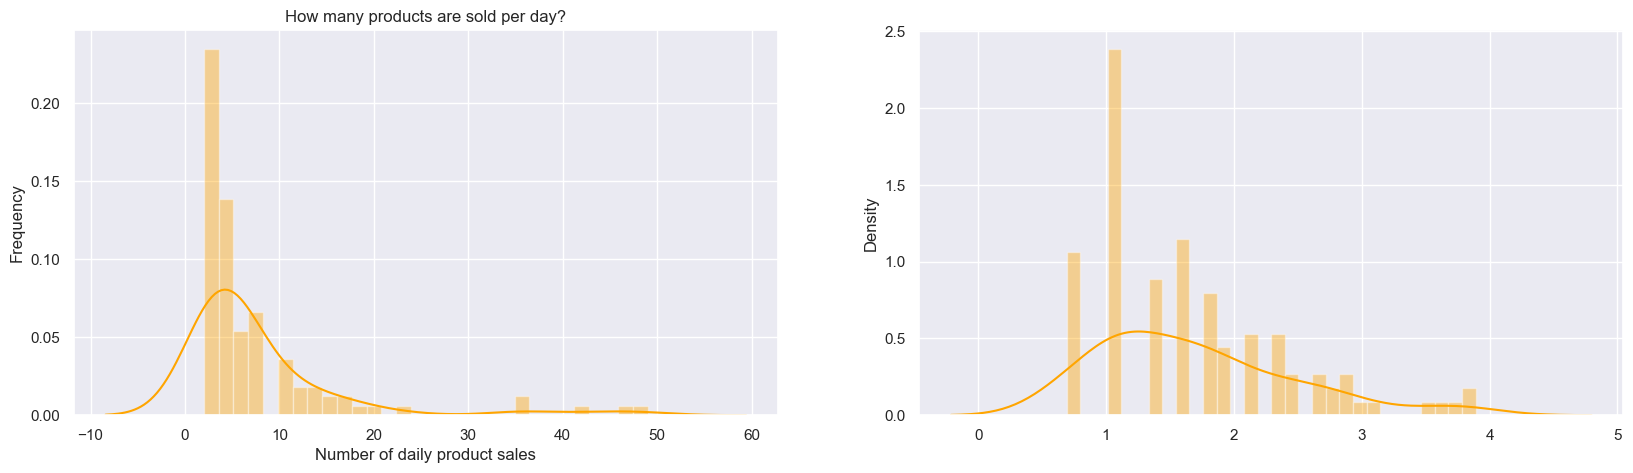

In [57]:
fig, ax = plt.subplots(1,2,figsize=(20,5))
sns.distplot(daily_data.Quantidade.values, kde=True, ax=ax[0], color="Orange", bins=30);
sns.distplot(np.log(daily_data.Quantidade.values), kde=True, ax=ax[1], color="Orange", bins=30);
ax[0].set_xlabel("Number of daily product sales");
ax[0].set_ylabel("Frequency");
ax[0].set_title("How many products are sold per day?");

In [58]:
class CatHyperparameter:

  def __init__(self,
               loss="RMSE",
               metric="RMSE", 
               iterations=1000, 
               max_depth=4,
               l2_leaf_reg=3,
               seed=0):
    
        self.loss = loss,
        self.metric = metric,
        self.max_depth = max_depth,
        self.l2_leaf_reg = l2_leaf_reg,
        #self.learning_rate = learning_rate,
        self.iterations=iterations
        self.seed = seed

In [59]:
class Catmodel:
    
    def __init__(self, name, params):
        self.name = name
        self.params = params
    
    def set_data_pool(self, train_pool, val_pool):
        self.train_pool = train_pool
        self.val_pool = val_pool
    
    def set_data(self, X, y, week):
        cat_features_idx = np.where(X.dtypes != np.float)[0]
        x_train, self.x_val = X.loc[X.Week < week], X.loc[X.Week >= week]
        y_train, self.y_val = y.loc[X.Week < week], y.loc[X.Week >= week]
        self.train_pool = Pool(x_train, y_train, cat_features=cat_features_idx)
        self.val_pool = Pool(self.x_val, self.y_val, cat_features=cat_features_idx)
    
    def prepare_model(self):
        self.model = CatBoostRegressor(
                loss_function = self.params.loss[0],
                random_seed = self.params.seed,
                logging_level = 'Silent',
                iterations = self.params.iterations,
                max_depth = self.params.max_depth[0],
                #learning_rate = self.params.learning_rate[0],
                l2_leaf_reg = self.params.l2_leaf_reg[0],
                od_type='Iter',
                od_wait=40,
                train_dir=self.name,
                has_time=True
            )
    
    def learn(self, plot=False):
        self.prepare_model()
        self.model.fit(self.train_pool, eval_set=self.val_pool, plot=plot);
        print("{}, early-stopped model tree count {}".format(
            self.name, self.model.tree_count_
        ))
    
    def score(self):
        return self.model.score(self.val_pool)
    
    def show_importances(self, kind="bar"):
        explainer = shap.TreeExplainer(self.model)
        shap_values = explainer.shap_values(self.val_pool)
        if kind=="bar":
            return shap.summary_plot(shap_values, self.x_val, plot_type="bar")
        return shap.summary_plot(shap_values, self.x_val)
    
    def get_val_results(self):
        self.results = pd.DataFrame(self.y_val)
        self.results["prediction"] = self.predict(self.x_val)
        self.results["error"] = np.abs(
            self.results[self.results.columns.values[0]].values - self.results.prediction)
        self.results["Month"] = self.x_val.Month
        self.results["SquaredError"] = self.results.error.apply(lambda l: np.power(l, 2))
    
    def show_val_results(self):
        self.get_val_results()
        fig, ax = plt.subplots(1,2,figsize=(20,5))
        sns.distplot(self.results.error, ax=ax[0])
        ax[0].set_xlabel("Single absolute error")
        ax[0].set_ylabel("Density")
        self.median_absolute_error = np.median(self.results.error)
        print("Median absolute error: {}".format(self.median_absolute_error))
        ax[0].axvline(self.median_absolute_error, c="black")
        ax[1].scatter(self.results.prediction.values,
                      self.results[self.results.columns[0]].values,
                      c=self.results.error, cmap="RdYlBu_r", s=1)
        ax[1].set_xlabel("Prediction")
        ax[1].set_ylabel("Target")
        return ax
    
    def get_monthly_RMSE(self):
        return self.results.groupby("Month").SquaredError.mean().apply(lambda l: np.sqrt(l))
        
    def predict(self, x):
        return self.model.predict(x)
    
    def get_dependence_plot(self, feature1, feature2=None):
        explainer = shap.TreeExplainer(self.model)
        shap_values = explainer.shap_values(self.val_pool)
        if feature2 is None:
            return shap.dependence_plot(
                feature1,
                shap_values,
                self.x_val,
            )
        else:
            return shap.dependence_plot(
                feature1,
                shap_values,
                self.x_val,
                interaction_index=feature2
            )
    

In [60]:
!pip install GPyOpt

In [61]:
import GPyOpt

class Hypertuner:
    
    def __init__(self, model, max_iter=10, max_time=10,max_depth=6, max_l2_leaf_reg=20):
        self.bounds = [{'name': 'depth','type': 'discrete','domain': (1,max_depth)},
                       {'name': 'l2_leaf_reg','type': 'discrete','domain': (1,max_l2_leaf_reg)}]
        self.model = model
        self.max_iter=max_iter
        self.max_time=max_time
        self.best_depth = None
        self.best_l2_leaf_reg = None
    
    def objective(self, params):
        params = params[0]
        params = CatHyperparameter(
            max_depth=params[0],
            l2_leaf_reg=params[1]
        )
        self.model.params = params
        self.model.learn()
        return self.model.score()
    
    def learn(self):
        np.random.seed(777)
        optimizer = GPyOpt.methods.BayesianOptimization(
            f=self.objective, domain=self.bounds,
            acquisition_type ='EI',
            acquisition_par = 0.2,
            exact_eval=True)
        optimizer.run_optimization(self.max_iter, self.max_time)
        optimizer.plot_convergence()
        best = optimizer.X[np.argmin(optimizer.Y)]
        self.best_depth = best[0]
        self.best_l2_leaf_reg = best[1]
        print("Optimal depth is {} and optimal l2-leaf-reg is {}".format(self.best_depth, self.best_l2_leaf_reg))
        print('Optimal RMSE:', np.min(optimizer.Y))
    
    def retrain_catmodel(self):
        params = CatHyperparameter(
            max_depth=self.best_depth,
            l2_leaf_reg=self.best_l2_leaf_reg
        )
        self.model.params = params
        self.model.learn(plot=True)
        return self.model

In [62]:
class CatFamily:
    
    def __init__(self, params, X, y, n_splits=2):
        self.family = {}
        self.cat_features_idx = np.where(X.dtypes != np.float)[0]
        self.X = X.values
        self.y = y.values
        self.n_splits = n_splits
        self.params = params
    
    def set_validation_strategy(self):
        self.cv = TimeSeriesSplit(max_train_size = None,
                                  n_splits = self.n_splits)
        self.gen = self.cv.split(self.X)
    
    def get_split(self):
        train_idx, val_idx = next(self.gen)
        x_train, x_val = self.X[train_idx], self.X[val_idx]
        y_train, y_val = self.y[train_idx], self.y[val_idx]
        train_pool = Pool(x_train, y_train, cat_features=self.cat_features_idx)
        val_pool = Pool(x_val, y_val, cat_features=self.cat_features_idx)
        return train_pool, val_pool
    
    def learn(self):
        self.set_validation_strategy()
        self.model_names = []
        self.model_scores = []
        for split in range(self.n_splits):
            name = 'Model_cv_' + str(split) + '/'
            train_pool, val_pool = self.get_split()
            self.model_names.append(name)
            self.family[name], score = self.fit_catmodel(name, train_pool, val_pool)
            self.model_scores.append(score)
    
    def fit_catmodel(self, name, train_pool, val_pool):
        cat = Catmodel(name, train_pool, val_pool, self.params)
        cat.prepare_model()
        cat.learn()
        score = cat.score()
        return cat, score
    
    def score(self):
        return np.mean(self.model_scores)
    
    def show_learning(self):
        widget = MetricVisualizer(self.model_names)
        widget.start()

    def show_importances(self):
        name = self.model_names[-1]
        cat = self.family[name]
        explainer = shap.TreeExplainer(cat.model)
        shap_values = explainer.shap_values(cat.val_pool)
        return shap.summary_plot(shap_values, X, plot_type="bar")

In [63]:
daily_data.head()


Quantidade  \
Date       Year   Quarter Month Week Weekday Dayofyear Day CodigoProduto               
2024-05-01 2024.0 2.0     5.0   18   2.0     122.0     1.0 693.0                49.0   
2024-05-02 2024.0 2.0     5.0   18   3.0     123.0     2.0 649.0                46.0   
                                                           655.0                42.0   
2024-05-03 2024.0 2.0     5.0   18   4.0     124.0     3.0 657.0                36.0   
                                                           659.0                35.0   

                                                                               Revenue  
Date       Year   Quarter Month Week Weekday Dayofyear Day CodigoProduto                
2024-05-01 2024.0 2.0     5.0   18   2.0     122.0     1.0 693.0          237454.00000  
2024-05-02 2024.0 2.0     5.0   18   3.0     123.0     2.0 649.0             193.34536  
                                                           655.0              59.03226  
2024-05-03 2024.0 2.0     5.0   18   4.0     124.0     3.0 657.0              49.77324  
                                                           659.0          509600.00000

In [64]:
week = data.Week.max() - 2
print("Validation after week {}".format(week))
print("Validation starts at timepoint {}".format(
    data[data.Week==week].Date.min()
))

Validation after week 20
Validation starts at timepoint 2024-05-13 00:00:00


In [ ]:
!pip uninstall numpy



In [ ]:
!pip install numpy==1.19.5


In [66]:
X = daily_data.drop(["Quantidade", "Revenue"], axis=1)
daily_data.Quantidade = np.log(daily_data.Quantidade)
y = data.Quantidade
params = CatHyperparameter()

model = Catmodel("baseline", params)
model.set_data(X,y, week)
model.learn(plot=True)

AttributeError: module 'numpy' has no attribute 'float'.
`np.float` was a deprecated alias for the builtin `float`. To avoid this error in existing code, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations